### Import Libraries & Define Utility Functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.metrics import classification_report, confusion_matrix

def show_confusion_matrix(confusion_matrix):
    """Adapted from Week 11 Live Session Notebook"""
    ax = plt.axes()
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='center')
    
    plt.ylabel('True Classification')
    plt.xlabel('Predicted Classification')
    
    plt.show()

### Load & pre-process Data Frame

In [2]:
import sys
sys.path.append("../data")

from process_data import process_data

X_train, y_train, X_test, y_test = process_data(buckets=10)

class_names = pd.concat([y_train['views_category_10'], y_test['views_category_10']]).unique().sort_values()

print("Before Cleanining")
X_train[['title','description']]

Before Cleanining


,title,description
2316,Filthiest Dunks in NBA History,The best dunks in NBA history. Let me know if ...
406,Rating EVERY American Cereal with Ludwig and A...,This will be the ultimate tier list of all the...
645,Easiest (and Hardest) Countries to Take Over,The world is filled with dominating military f...
1206,"$1 vs $1,000,000 Hotel Room!",The hotel at the end is worth the wait!\n\nDow...
592,Mayweather vs. Paul: Ceremonial Weigh-In | SHO...,Hall of Fame boxing legend Floyd Mayweather an...
...,...,...
1095,Elden Ring OFFICIAL DLC in Miquella's Dream Co...,The DLC is finally revealed! ELDEN RING: Shado...
1462,Kirby but tier list,Kirby Triple Deluxe but I finally have an opin...
2197,"LATEST! MARCH 18, 2023 PINOY boxer NO MERC...","LATEST! MARCH 18, 2023 PINOY boxer NO MERC..."
1039,As It Was - Harry Styles,🎶Lyrics:\nHoldin' me back\nGravity's holdin' m...


In [3]:
import nltk
from nltk.corpus import stopwords

def clean_text(text):
    """Function to clean up text by making all characters lowercase,
    removing non-alphanumeric characters, and removing common stop words"""

    # make the text lowercase
    text = text.lower()
    
    # remove non-alphabetic characters (including digits and punctuation)
    text = re.sub("[^a-zA-Z]", ' ', text)

    # remove common stop words
    stop_words = set(stopwords.words("english"))
    text = [w for w in text.split() if w not in stop_words]

    return " ".join(text)

X_train['description'] = X_train['description'].apply(clean_text)
X_test['description'] = X_test['description'].apply(clean_text)
X_train['title'] = X_train['title'].apply(clean_text)
X_test['title'] = X_test['title'].apply(clean_text)

print("After Cleaning")
X_train[['title','description']]

After Cleaning


,title,description
2316,filthiest dunks nba history,best dunks nba history let know make part than...
406,rating every american cereal ludwig abroad japan,ultimate tier list different cereal could find...
645,easiest hardest countries take,world filled dominating military forces around...
1206,vs hotel room,hotel end worth wait download experian app htt...
592,mayweather vs paul ceremonial weigh showtime ppv,hall fame boxing legend floyd mayweather socia...
...,...,...
1095,elden ring official dlc miquella dream confirm...,dlc finally revealed elden ring shadow erdtree...
1462,kirby tier list,kirby triple deluxe finally opinion thank note...
2197,latest march pinoy boxer mercy tinalo ang form...,latest march pinoy boxer mercy tinalo ang form...
1039,harry styles,lyrics holdin back gravity holdin back want ho...


### Classification Using Bag of Words Approach

Classify by Description
  1859 records containing 34427 unique words
              precision    recall  f1-score   support

           0       0.04      0.50      0.07         4
          10       0.16      0.23      0.19        31
          20       0.07      0.20      0.10        20
          30       0.25      0.09      0.13        88
          40       0.15      0.35      0.21        23
          50       0.29      0.10      0.14       103
          60       0.20      0.13      0.16        62
          70       0.02      0.06      0.03        17
          80       0.48      0.33      0.39        63
          90       0.58      0.54      0.56        54

    accuracy                           0.21       465
   macro avg       0.22      0.25      0.20       465
weighted avg       0.29      0.21      0.22       465



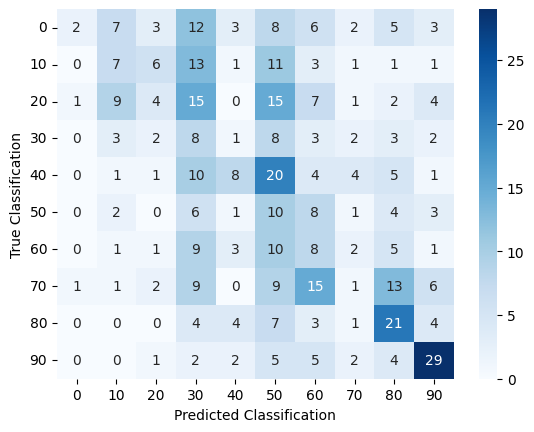


Classify by Title
  1859 records containing 15123 unique words
              precision    recall  f1-score   support

           0       0.33      0.06      0.10        51
          10       0.00      0.00      0.00        44
          20       0.18      0.03      0.06        58
          30       0.08      0.56      0.15        32
          40       0.11      0.02      0.03        54
          50       0.04      0.11      0.06        35
          60       0.15      0.10      0.12        40
          70       0.20      0.02      0.03        57
          80       0.12      0.05      0.07        44
          90       0.32      0.36      0.34        50

    accuracy                           0.11       465
   macro avg       0.15      0.13      0.10       465
weighted avg       0.16      0.11      0.09       465



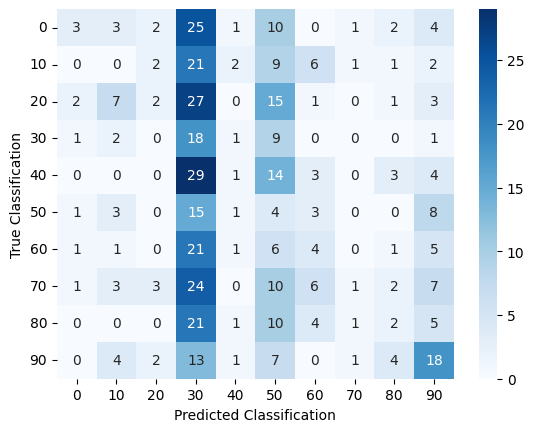

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


def classifyByText(X_train, Y_train, X_test, Y_test):
    count_vect = CountVectorizer()
    count_vect.fit(pd.concat([X_train, X_test]))
                   
    X_train_counts = count_vect.transform(X_train)

    print(f"  {X_train_counts.shape[0]:0d} records containing",
          f"{X_train_counts.shape[1]:0d} unique words")

    clf_MNB_pipe = Pipeline([("vect", CountVectorizer()), 
                             ("tfidf", TfidfTransformer()), 
                             ("clf_nominalNB", MultinomialNB())])
    clf_MNB_pipe.fit(X_train, Y_train)

    return clf_MNB_pipe.predict(X_test)

    
print("Classify by Description")
y_pred = classifyByText(X_train['description'], y_train['views_category_10'], 
                        X_test['description'], y_train['views_category_10'])
print(classification_report(y_pred, y_test['views_category_10']))

cm = confusion_matrix(y_test['views_category_10'], y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

print("")

print("Classify by Title")
y_pred = classifyByText(X_train['title'], y_train['views_category_10'], 
                        X_test['description'], y_train['views_category_10'])
print(classification_report(y_true=y_test['views_category_10'],
                            y_pred=y_pred))

cm = confusion_matrix(y_true=y_test['views_category_10'], 
                      y_pred=y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Classification Using Embeddings

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def classifyByTextEmbeddings(X_train, Y_train, X_test, Y_test,
                             vocab_size=5000, sequence_len=100,
                             embedding_dim=2, num_epochs=5):

    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(pd.concat([X_train, X_test]))

    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_train_padded_seq = pad_sequences(X_train_seq, 
                                       maxlen=sequence_len, 
                                       padding='post', 
                                       truncating='post')

    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        input_length=sequence_len))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=8, activation="relu"))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    display(model.summary())
    
    model.fit(
        x=X_train_padded_seq,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=1
    )
    
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_test_padded_seq = pad_sequences(X_test_seq, 
                                      maxlen=sequence_len, 
                                      padding='post', 
                                      truncating='post')

    metrics = model.evaluate(
                  x=X_test_padded_seq,
                  y=Y_test,
                  return_dict=True
              )
    
    print("")
    print(f"Test Loss: {metrics['loss']:0.4f}")
    print(f"Test Accuracy: {metrics['accuracy']:0.4f}")
    
    return model.predict(x=X_test_padded_seq)

Metal device set to: Apple M2 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           64000     
                                                                 
 conv1d (Conv1D)             (None, 93, 16)            4112      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
Total params: 68,282
Trainable params: 68,282
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/10
27/27 [==============================] - 1s 21ms/step - loss: 2.3004 - accuracy: 0.1004 - val_loss: 2.3000 - val_accuracy: 0.0860
Epoch 2/10
27/27 [==============================] - 0s 15ms/step - loss: 2.2921 - accuracy: 0.1273 - val_loss: 2.2965 - val_accuracy: 0.0860
Epoch 3/10
27/27 [==============================] - 0s 15ms/step - loss: 2.2803 - accuracy: 0.1273 - val_loss: 2.2879 - val_accuracy: 0.1022
Epoch 4/10
27/27 [==============================] - 0s 15ms/step - loss: 2.2602 - accuracy: 0.1715 - val_loss: 2.2654 - val_accuracy: 0.1344
Epoch 5/10
27/27 [==============================] - 0s 15ms/step - loss: 2.2278 - accuracy: 0.2379 - val_loss: 2.2369 - val_accuracy: 0.1935
Epoch 6/10
27/27 [==============================] - 0s 15ms/step - loss: 2.1808 - accuracy: 0.2947 - val_loss: 2.2078 - val_accuracy: 0.2043
Epoch 7/10
27/27 [==============================] - 0s 13ms/step - loss: 2.1193 - accuracy: 0.3234 - val_loss: 2.1698 - val_accuracy: 0.2312
Epoch 8/10
27

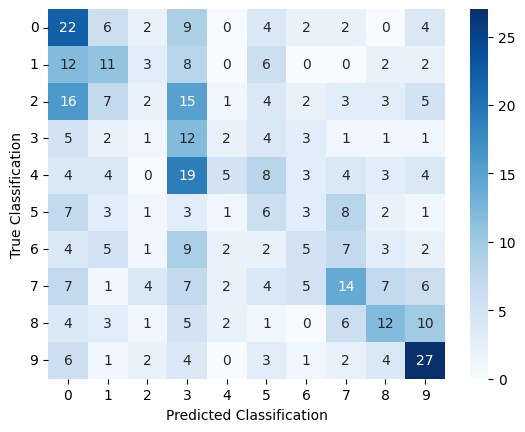

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(pd.concat([y_train['views_category_10'], y_test['views_category_10']]))

Y_train_cat = encoder.transform(y_train['views_category_10'])
Y_test_cat = encoder.transform(y_test['views_category_10'])

class_names = np.unique(np.concatenate((Y_train_cat, Y_test_cat)))
class_names.sort()

Y_pred = classifyByTextEmbeddings(X_train=X_train['description'], 
                                  Y_train=Y_train_cat,
                                  X_test=X_test['description'],
                                  Y_test=Y_test_cat,
                                  vocab_size=2000, sequence_len=100,
                                  embedding_dim=32, num_epochs=10)

Y_pred_cat = [np.argmax(x) for x in Y_pred]
print(classification_report(y_true=Y_test_cat, y_pred=Y_pred_cat))

cm = confusion_matrix(y_true=Y_test_cat, y_pred=Y_pred_cat)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 conv1d (Conv1D)             (None, 43, 16)            2064      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
Total params: 18,234
Trainable params: 18,234
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/10
27/27 [==============================] - 1s 26ms/step - loss: 2.3028 - accuracy: 0.1040 - val_loss: 2.3031 - val_accuracy: 0.1290
Epoch 2/10
27/27 [==============================] - 0s 16ms/step - loss: 2.3016 - accuracy: 0.1154 - val_loss: 2.3051 - val_accuracy: 0.1022
Epoch 3/10
27/27 [==============================] - 0s 14ms/step - loss: 2.3011 - accuracy: 0.1088 - val_loss: 2.3075 - val_accuracy: 0.1022
Epoch 4/10
27/27 [==============================] - 0s 12ms/step - loss: 2.2997 - accuracy: 0.1088 - val_loss: 2.3068 - val_accuracy: 0.1022
Epoch 5/10
27/27 [==============================] - 0s 12ms/step - loss: 2.2979 - accuracy: 0.1088 - val_loss: 2.3044 - val_accuracy: 0.1075
Epoch 6/10
27/27 [==============================] - 0s 13ms/step - loss: 2.2949 - accuracy: 0.1160 - val_loss: 2.3044 - val_accuracy: 0.1129
Epoch 7/10
27/27 [==============================] - 0s 11ms/step - loss: 2.2901 - accuracy: 0.1184 - val_loss: 2.3036 - val_accuracy: 0.1075
Epoch 8/10
27

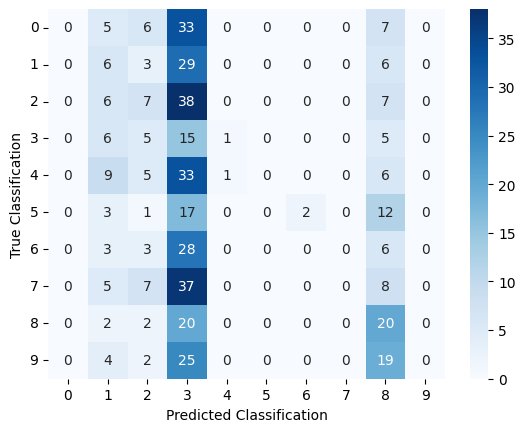

In [7]:
Y_pred = classifyByTextEmbeddings(X_train=X_train['title'], 
                                  Y_train=Y_train_cat,
                                  X_test=X_test['title'],
                                  Y_test=Y_test_cat,
                                  vocab_size=1000, sequence_len=50,
                                  embedding_dim=16, num_epochs=10)

Y_pred_cat = [np.argmax(x) for x in Y_pred]
print(classification_report(y_true=Y_test_cat, y_pred=Y_pred_cat))

cm = confusion_matrix(y_true=Y_test_cat, y_pred=Y_pred_cat)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Classification using Transformers

In [8]:
import torch
import torch.nn as nn

from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup

from collections import defaultdict
from transformers_util import TextDataset, ViewCategoryClassifier, create_data_loader
from transformers_util import train_epoch, eval_model, get_predictions

from sklearn.model_selection import train_test_split

"""Code adapted from W207 Week 13 Session Notebook on Sentiment Analysis using Transformers"""

PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
BATCH_SIZE = 32
EPOCHS = 10

def run_experiment(X_train, train_data_loader, X_val, val_data_loader, X_test, test_data_loader):
    """Given a training, validation, and test dataset, train a transformer model using the training
    dataset, evaluate the model's accuracy against the validation dataset after each EPOCH,
    make predictions using the test dataset and evaluate the model's accuracy"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = ViewCategoryClassifier(len(class_names), PRE_TRAINED_MODEL_NAME)
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(X_train)
        )
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(X_val)
        )
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    y_text_texts, y_pred, y_pred_probs, y_test = get_predictions(
        model,
        test_data_loader,
        device
    )

    print(classification_report(y_true=y_test.numpy(), y_pred=y_pred.numpy()))

    cm = confusion_matrix(y_true=y_test.numpy(), 
                          y_pred=y_pred.numpy())
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    show_confusion_matrix(df_cm)

#### Train and test model using YouTube video descriptions

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------
Train loss 2.326213836669922 accuracy 0.10340705319784818
Val   loss 2.3015234073003135 accuracy 0.11290322580645161

Epoch 2/10
----------
Train loss 2.322800987171677 accuracy 0.1087866108786611
Val   loss 2.2997299432754517 accuracy 0.12365591397849462

Epoch 3/10
----------
Train loss 2.3004762361634454 accuracy 0.12851165570830841
Val   loss 2.286363164583842 accuracy 0.10752688172043011

Epoch 4/10
----------
Train loss 2.2893210087182387 accuracy 0.12193664076509265
Val   loss 2.284064451853434 accuracy 0.12365591397849462

Epoch 5/10
----------
Train loss 2.2851545720730186 accuracy 0.12014345487148835
Val   loss 2.274479945500692 accuracy 0.13440860215053763

Epoch 6/10
----------
Train loss 2.276060954579767 accuracy 0.12851165570830841
Val   loss 2.276882608731588 accuracy 0.11290322580645161

Epoch 7/10
----------
Train loss 2.260685039016436 accuracy 0.13508667065152422
Val   loss 2.2828115622202554 accuracy 0.11290322580645161

Epoch 8/10
----------


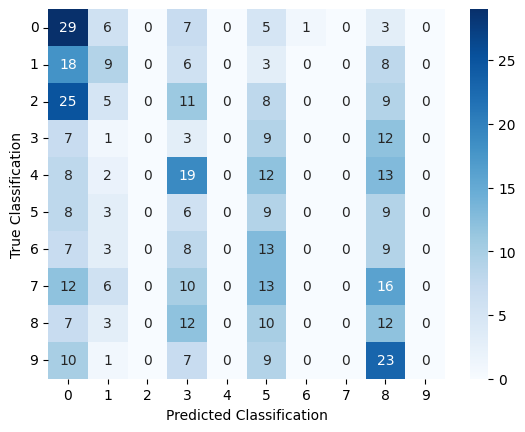

In [9]:
# create a validation dataset from our training data set
X_train_1, X_val, Y_train_cat_1, Y_val_cat = train_test_split(X_train, Y_train_cat, test_size=0.1, shuffle=True)

MAX_LEN = 100

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(X_train_1['description'], Y_train_cat_1, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(X_val['description'], Y_val_cat, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test['description'], Y_test_cat, tokenizer, MAX_LEN, BATCH_SIZE)

run_experiment(X_train_1, train_data_loader, X_val, val_data_loader, X_test, test_data_loader)

#### Train and test model with YouTube video titles

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------
Train loss 2.3201645635208994 accuracy 0.09623430962343096
Val   loss 2.30395237604777 accuracy 0.11290322580645161

Epoch 2/10
----------
Train loss 2.3041780444810973 accuracy 0.1195457262402869
Val   loss 2.305797020594279 accuracy 0.10752688172043011

Epoch 3/10
----------
Train loss 2.2878323231103286 accuracy 0.13090257023311416
Val   loss 2.278870781262716 accuracy 0.11290322580645161

Epoch 4/10
----------
Train loss 2.2530799361894713 accuracy 0.14465032875074715
Val   loss 2.2612749338150024 accuracy 0.14516129032258066

Epoch 5/10
----------
Train loss 2.1892101179878667 accuracy 0.17035265989240886
Val   loss 2.2497549851735434 accuracy 0.14516129032258066

Epoch 6/10
----------
Train loss 2.1442062674828297 accuracy 0.17752540346682605
Val   loss 2.2627123594284058 accuracy 0.13440860215053763

Epoch 7/10
----------
Train loss 2.0993446651494727 accuracy 0.20561864913329347
Val   loss 2.2770453691482544 accuracy 0.11290322580645161

Epoch 8/10
-------

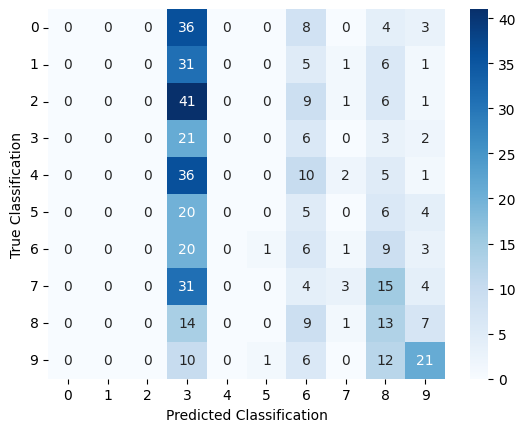

In [10]:
MAX_LEN = 50

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(X_train_1['title'], Y_train_cat_1, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(X_val['title'], Y_val_cat, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test['title'], Y_test_cat, tokenizer, MAX_LEN, BATCH_SIZE)

run_experiment(X_train_1, train_data_loader, X_val, val_data_loader, X_test, test_data_loader)